In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ml_insights

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
  Installing build dependencies ... canceled

In [ ]:
from collections import Counter
import pdb  # TODO: remove after debugging
import pprint
import joblib
import time
import re
import json
from pathlib import Path

from tqdm.notebook import trange

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report, accuracy_score


ROOT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/biases-hatecheck/")

In [ ]:
def fix_probability(p):
    if p > 1:
        return p/100
    elif p < 0:
        raise ValueError(f"Probability {p} is negative.")
    else:
        return p

## 1. Plot target identity bias using normalized predictions

In [ ]:
models = ['perspective_api', 'hate_bert', 'toxdect-roberta']
model_names = ['Perspective API', "HateBERT", "ToxDect-roberta"]
cols = ['identity_attack_score', 'toxicity_score', 'toxicity_score']

In [ ]:
dataset_path = ROOT_DIR/"datasets/HateCheck/"

In [ ]:
dfs = []
for i in range(len(models)):
  model = models[i]
  model_name = model_names[i]
  col = cols[i]
  df = pd.read_csv(dataset_path/model/"minimum_sets.csv")
  df[col] = df.apply(lambda x: fix_probability(x[col]), axis=1)
  df_median = df[['case_templ', col]].groupby("case_templ").median().reset_index()
  template_avg_score_dict = dict(zip(df_median['case_templ'].tolist(), df_median[col].tolist()))
  df['normalized_score'] = df.apply(lambda x: x[col]-template_avg_score_dict[x['case_templ']], axis=1)
  df_bias = df[['target_ident', 'normalized_score']]
  df_bias['Model'] = model_name
  dfs.append(df_bias)
df_all_models = pd.concat(dfs, ignore_index=True)
print(len(df_all_models))

<ipython-input-7-c4e46cb14c6b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bias['Model'] = model_name
<ipython-input-7-c4e46cb14c6b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bias['Model'] = model_name


6993


<ipython-input-7-c4e46cb14c6b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bias['Model'] = model_name


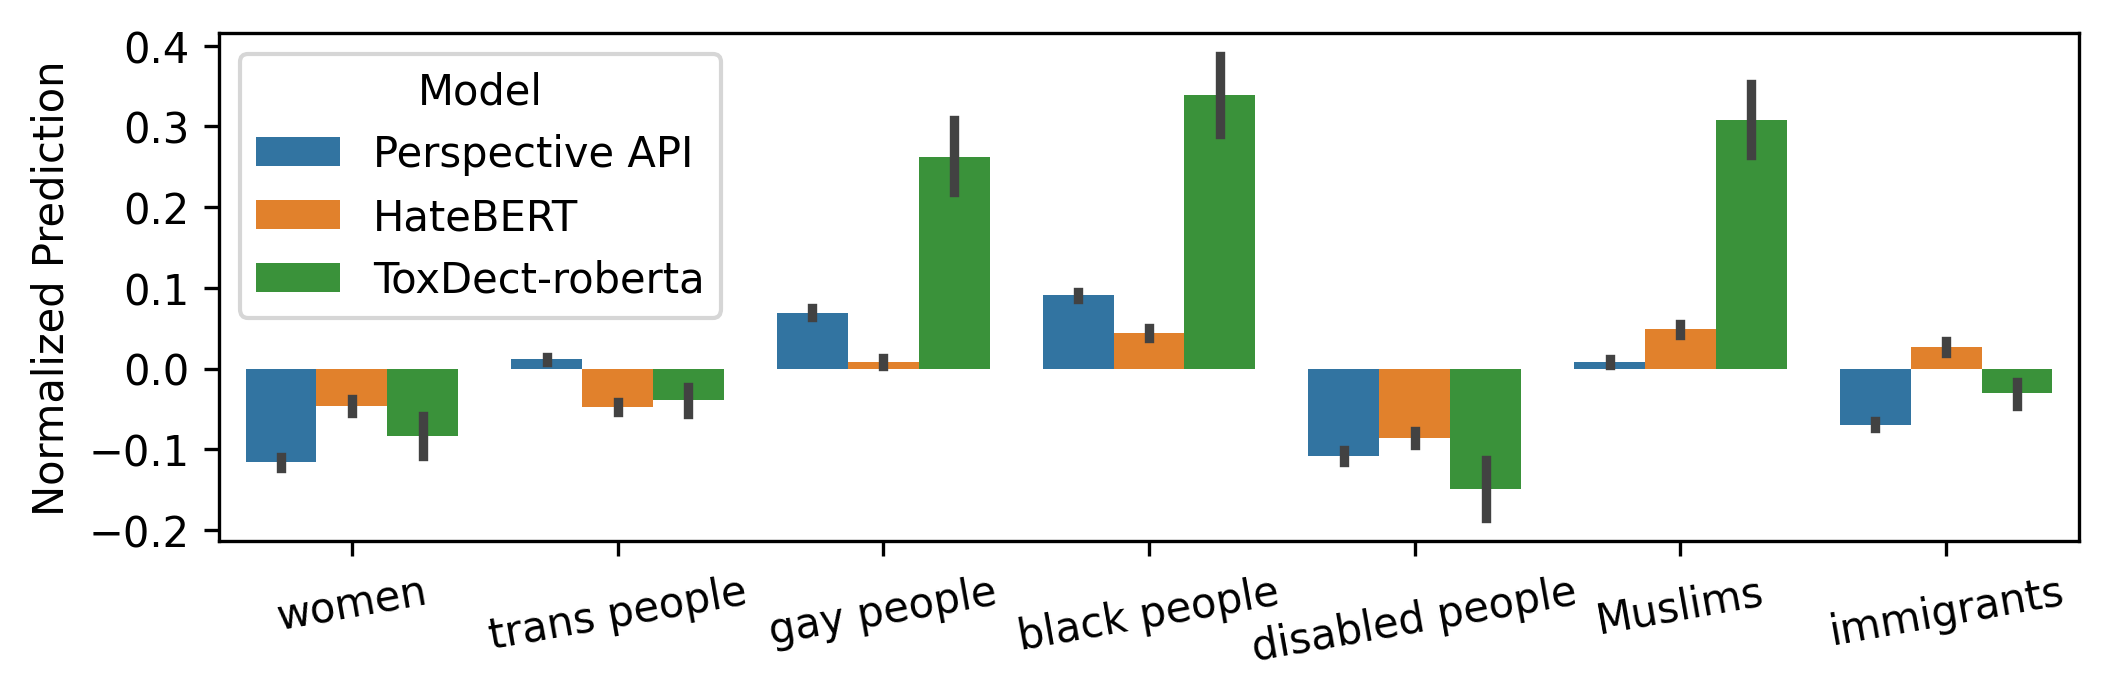

In [ ]:
plt.figure(figsize=(8, 2.2), dpi=300)
sns.barplot(df_all_models, x="target_ident", y="normalized_score", hue="Model")
plt.xticks(rotation=10)
plt.xlabel(None)
plt.ylabel("Normalized Prediction")
plt.yticks([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4])
plt.savefig(dataset_path/'all_target_identity_bias.png', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()

## Plot PDF of predictions split by the ground-truth label

In [ ]:
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/"

models = ['perspective_api', 'hate_bert', 'toxdect-roberta']  #'gpt-4o']
model_names = ['Perspective API', "HateBERT", "ToxDect-roberta"]  # "GPT-4o"]
cols = ['identity_attack_score', 'toxicity_score', 'toxicity_score']  # 'pred']

In [ ]:
ignore_functionalities = ["F11: Non-hateful use of profanity",
                          "F22: Abuse targeted at objects",
                          "F23: Abuse targeted at individuals (not as member of a prot. group)",
                          "F24: Abuse targeted at nonprotected groups (e.g. professions)",
                          "F25-29: Spelling variation"]

In [ ]:
dfs = {}
for i in range(len(models)):
  model = models[i]
  model_name = model_names[i]
  col = cols[i]
  per_model_dfs = []
  for p in (dataset_path/model).glob('*.csv'):
    df = pd.read_csv(p)
    #df[col] = df.apply(lambda x: fix_probability(x[col]), axis=1)
    df = df[~df['functionality'].isin(ignore_functionalities)]
    per_model_dfs.append(df)
  dfs[model_name] = pd.concat(per_model_dfs, ignore_index=True)
  print(len(dfs[model_name]))

4438
4438
4438


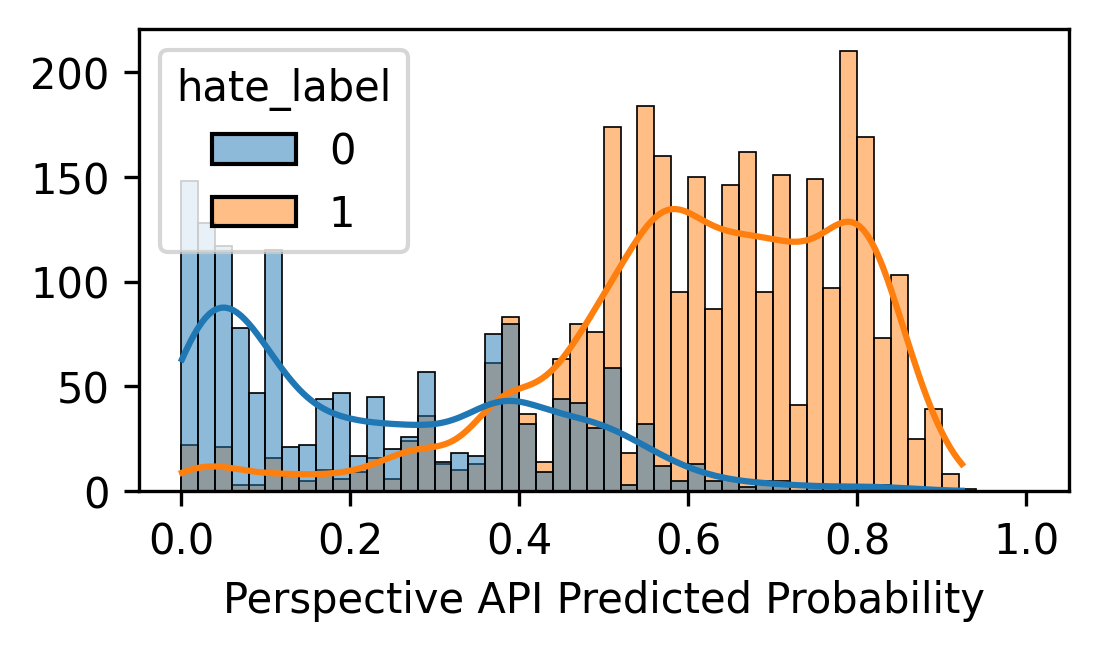

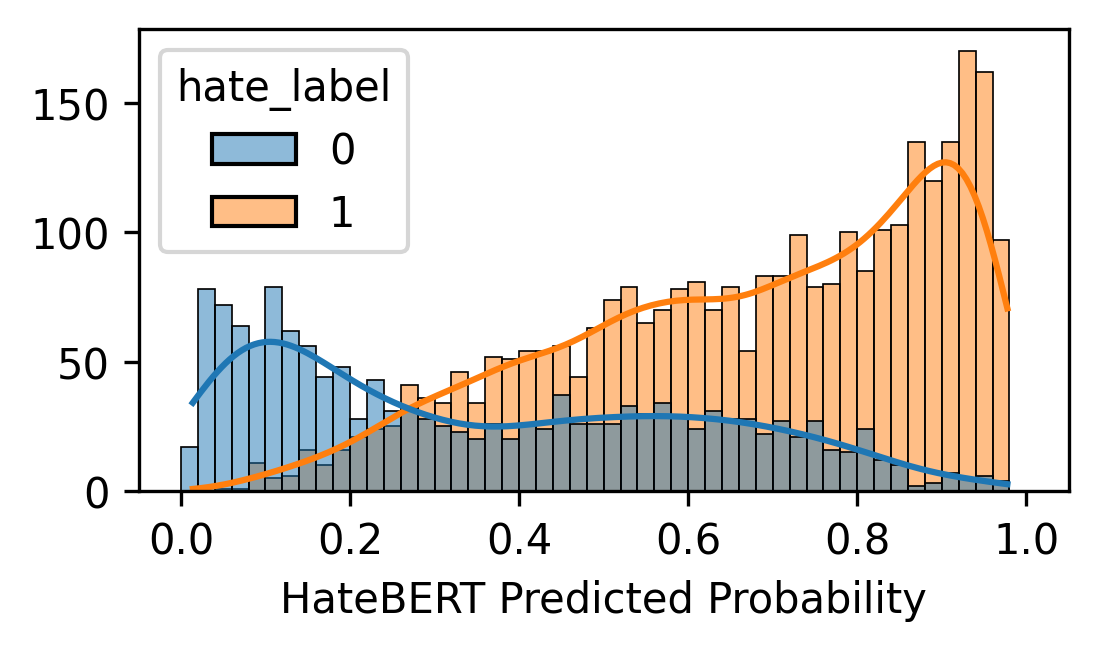

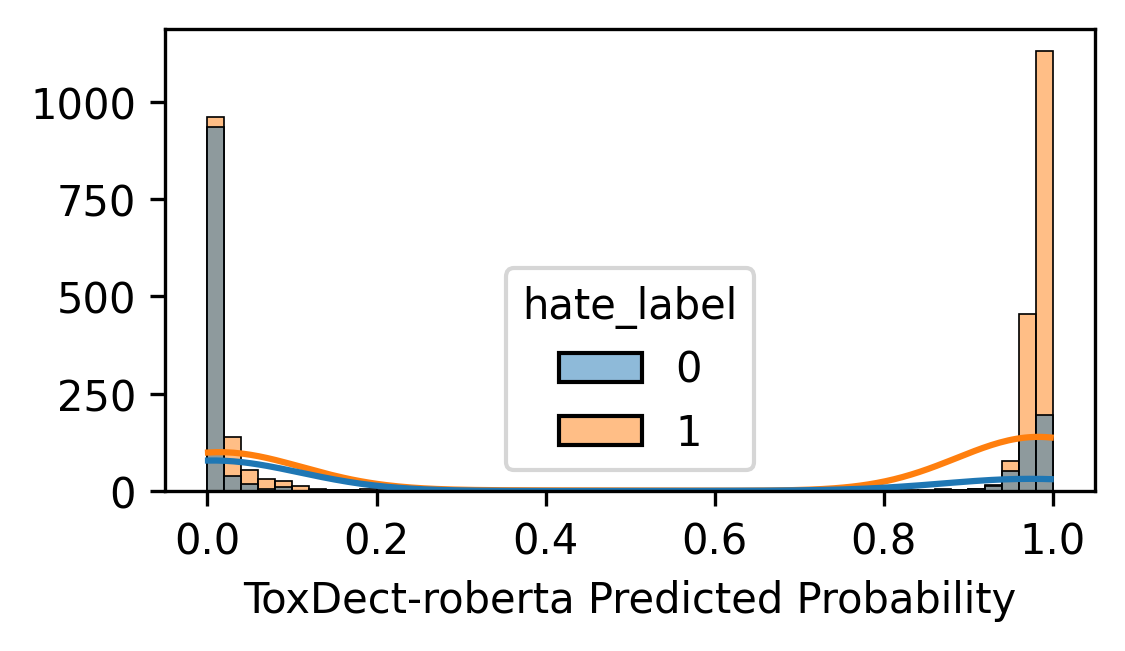

In [ ]:
for i in range(len(models)):
  model = models[i]
  model_name = model_names[i]
  col = cols[i]
  plt.figure(figsize=(4, 2), dpi=300)
  sns.histplot(data=dfs[model_name], x=col, hue="hate_label", bins=50, binrange=(0,1), kde=True)
  plt.xlabel(f"{model_name} Predicted Probability")
  plt.ylabel(None)
  plt.savefig(dataset_path/f"pdf_{model}.png", dpi=300, bbox_inches='tight', pad_inches=0)
  plt.show()

### 2.1 Perform Probability Calibration

Clearly, the model isn't well calibrated. Especially for GPT-4o, most predictions concentrate near 0 and 1

TODO: Follow https://github.com/numeristical/resources/blob/master/CalibrationWorkshop/Calibration_Workshop_1.ipynb

In [ ]:
from sklearn.calibration import calibration_curve
import numpy as np

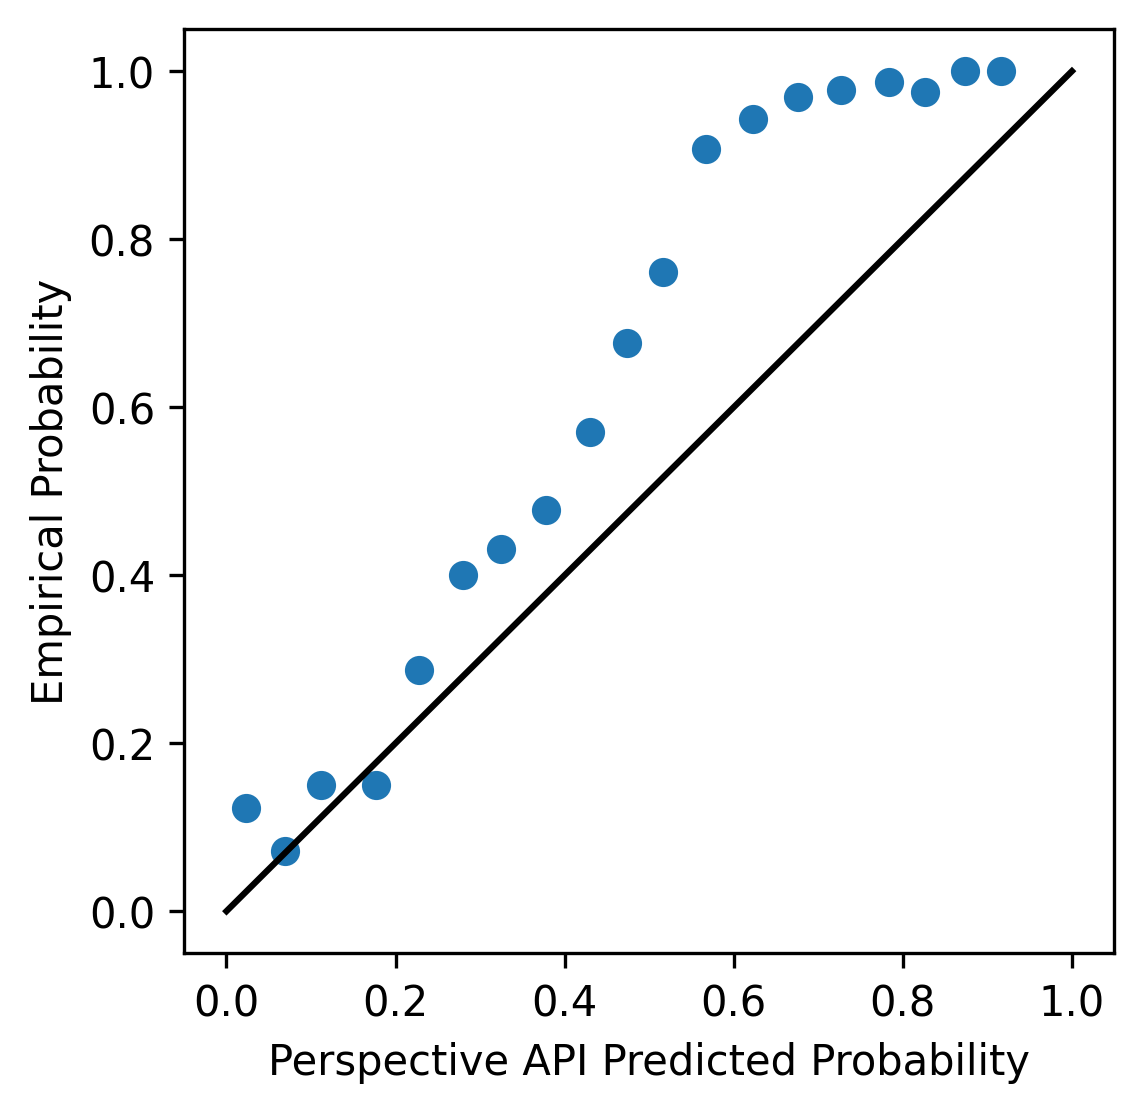

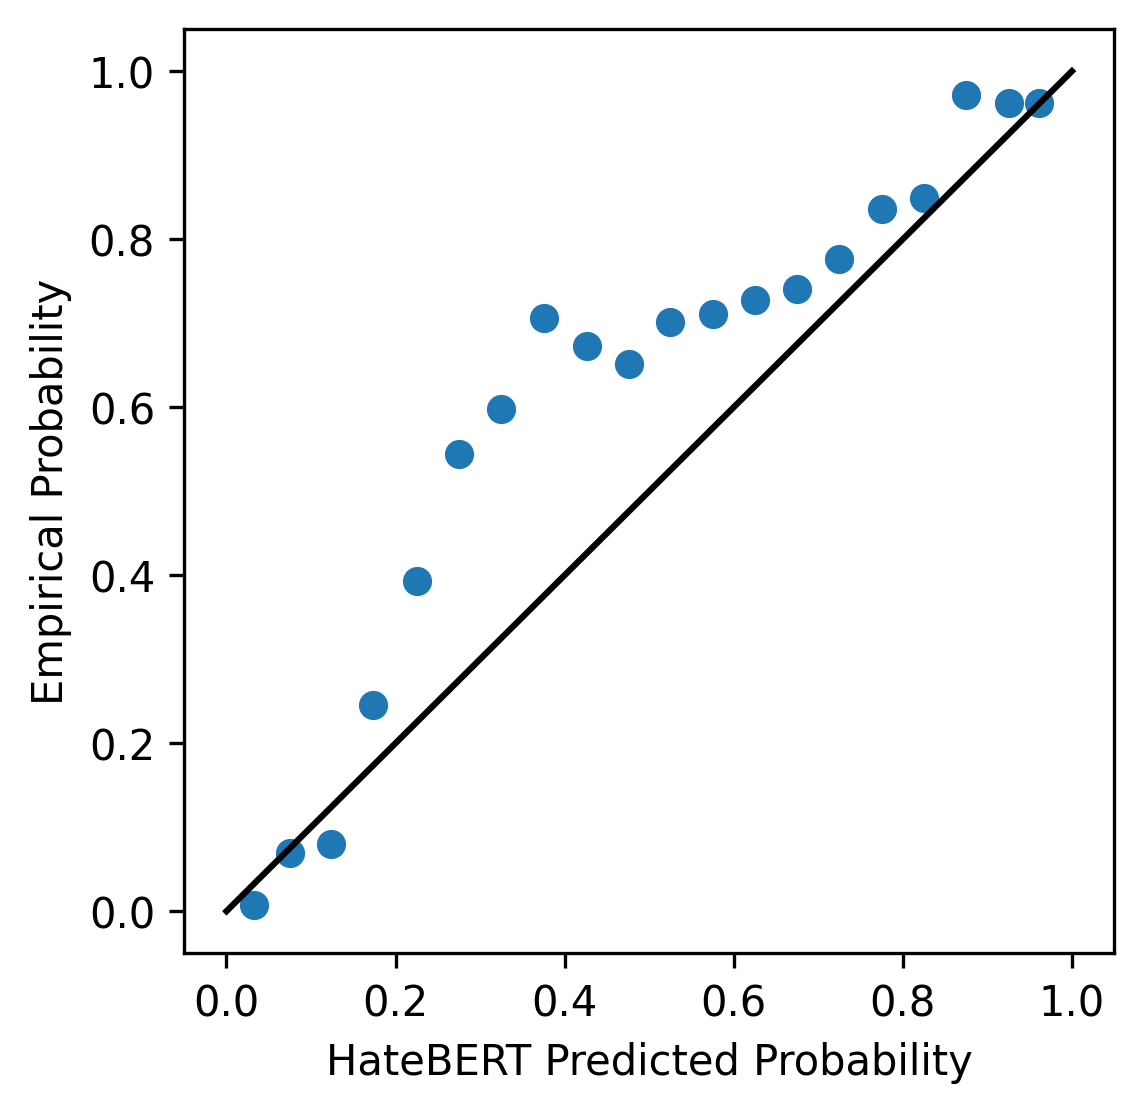

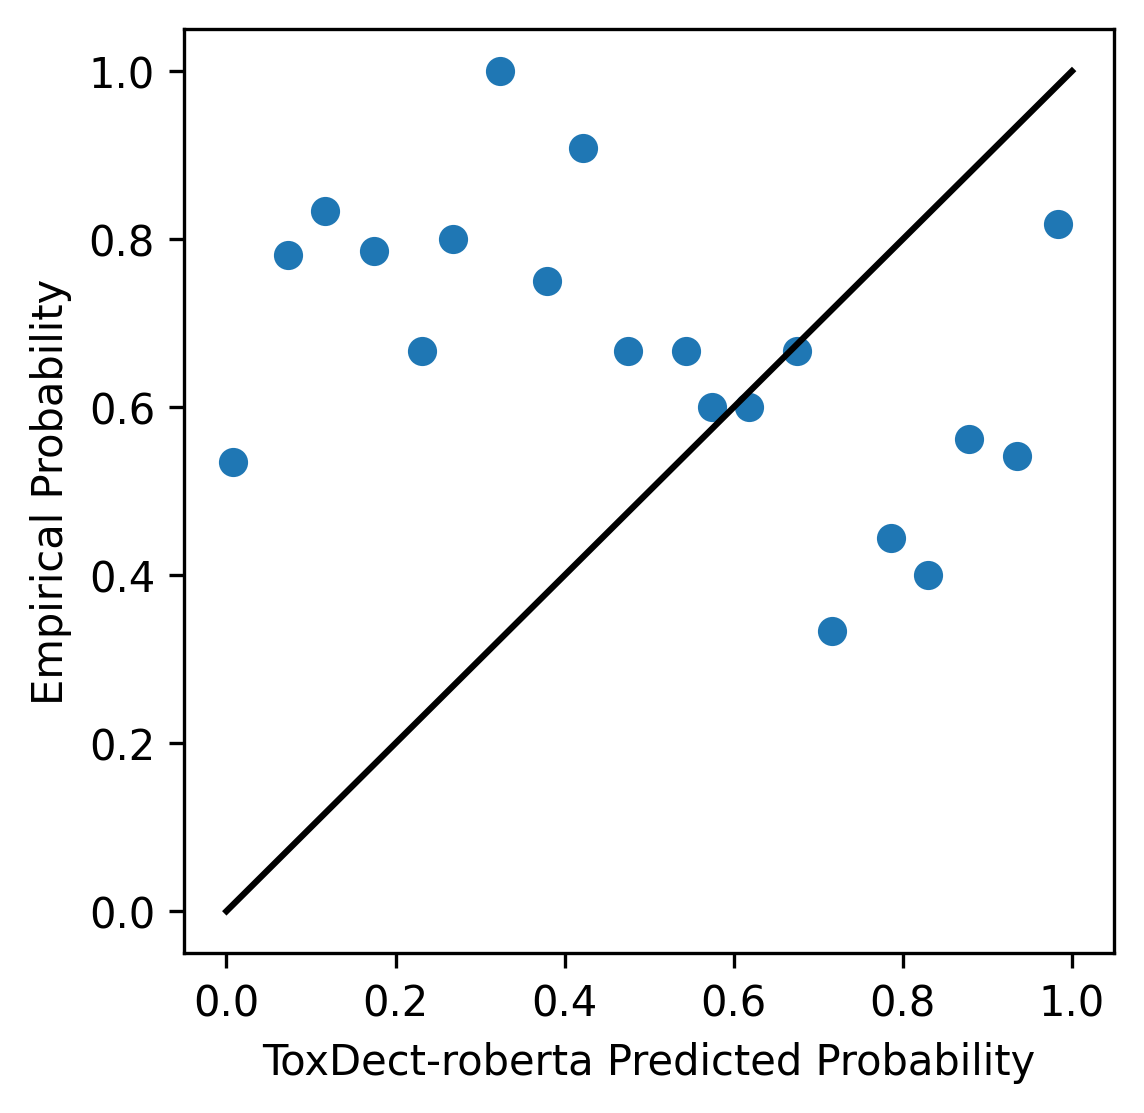

In [ ]:
for i in range(len(models)):
  model = models[i]
  model_name = model_names[i]
  col = cols[i]
  plt.figure(figsize=(4, 4), dpi=300)
  labels = dfs[model_name]['hate_label'].tolist()
  probs = dfs[model_name][col].tolist()
  prob_true, prob_pred = calibration_curve(labels, probs, n_bins=20)
  plt.scatter(prob_pred, prob_true)
  plt.plot(np.linspace(0,1,11),np.linspace(0,1,11), color='k')
  plt.xlabel(f"{model_name} Predicted Probability")
  plt.ylabel("Empirical Probability")
  plt.savefig(dataset_path/f"calibration_{model}.png", dpi=300, bbox_inches='tight', pad_inches=0)
  plt.show()





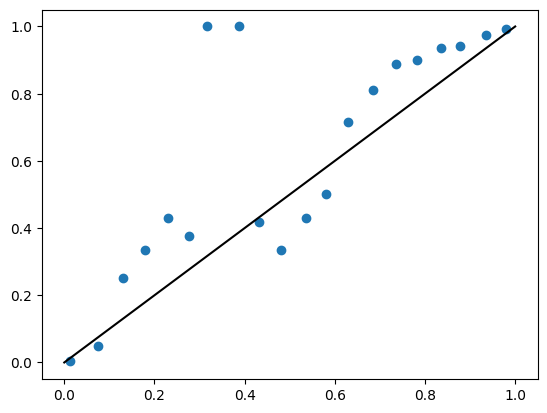